In [1]:
import pandas as pd
from backtest import BacktestEngine
from backtest import ComparisonBacktest

In [2]:
svol = pd.read_csv('data/svol.csv', index_col=0)
spy_df = pd.read_csv('data/spy_df.csv', index_col=0)
spy_df = spy_df.reset_index()
spy_df = spy_df.rename(columns={'date': 'Date'})
spy_df = spy_df.rename(columns={'adj_close': 'Adj Close'})
fama_french = pd.read_csv('data/F-F_Research_Data_Factors_daily.csv')
fama_french = fama_french.iloc[:-2]
fama_french.rename(columns={fama_french.columns[0]: 'date'}, inplace=True)
fama_french['date'] = pd.to_datetime(fama_french['date'], format='%Y%m%d')
fama_french = fama_french.iloc[:, :-1]

def get_backtesting_results(strategy):
    results = BacktestEngine(strategy, spy_df, fama_french, svol)

    for key, value in results.get_all_metrics().items():
        print(f"{key:<40} : {value}")
    results.plot_strategy()
    results.plot_svol_vs_strategy_vol()
    results.plot_rolling_volatility()
    results.plot_drawdown()
    results.plot_return_distribution()

In [3]:
market_hedge = pd.read_csv('data/market_hedge_series.csv')
mk_hedge = market_hedge[['Date', 'Portfolio Returns']]
mk_hedge.dropna(subset=['Portfolio Returns'], inplace=True)
mk_hedge

/var/folders/6k/w04x8wkd07sgkq3v_8pvdspr0000gn/T/ipykernel_54112/1118164581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mk_hedge.dropna(subset=['Portfolio Returns'], inplace=True)


,Date,Portfolio Returns
1,2014-11-04,-0.005888
2,2014-11-05,-0.012833
3,2014-11-06,0.007000
4,2014-11-07,-0.000993
5,2014-11-10,0.008946
...,...,...
2218,2023-08-28,0.000481
2219,2023-08-29,0.008453
2220,2023-08-30,0.001185
2221,2023-08-31,0.000588


In [4]:
rates_hedge = pd.read_csv('return/rates_hedge_return.csv')
rates_hedge.dropna(subset=['Rates Hedge Only Return'], inplace=True)
rates_hedge

,Date,ARKK Unhedged Return,Hedged Gross Return,Hedged Net Return,Rates Hedge Only Return,Rates Hedge PnL
164,2015-08-27,0.030805,0.030805,0.030805,0.000000,0.000000e+00
165,2015-08-28,0.009778,0.009778,0.009778,0.000000,0.000000e+00
166,2015-08-31,-0.006917,-0.006917,-0.006917,0.000000,0.000000e+00
167,2015-09-01,-0.036318,-0.036318,-0.036318,0.000000,0.000000e+00
168,2015-09-02,0.011100,0.011100,0.011100,0.000000,0.000000e+00
...,...,...,...,...,...,...
2608,2025-05-14,0.002613,0.002372,0.002371,-0.000242,-2.179304e+06
2609,2025-05-15,-0.014420,-0.014296,-0.014298,0.000122,1.100363e+06
2610,2025-05-16,0.028909,0.028052,0.028050,-0.000859,-7.728687e+06
2611,2025-05-19,-0.016618,-0.015602,-0.015604,0.001014,9.125496e+06


In [5]:
combined = pd.merge(
    mk_hedge,
    rates_hedge[['Date', 'Rates Hedge Only Return', 'ARKK Unhedged Return']],
    on='Date',
    how='inner'
)

combined['Overall Hedge Return'] = combined['Portfolio Returns'] + combined['Rates Hedge Only Return']
combined['Options Hedge Only Return'] = combined['Portfolio Returns'] - combined['ARKK Unhedged Return']
combined.drop(columns=['Portfolio Returns'], inplace=True)
combined = combined.rename(columns={'Date': 'date'})
combined

,date,Rates Hedge Only Return,ARKK Unhedged Return,Overall Hedge Return,Options Hedge Only Return
0,2015-08-27,0.000000,0.030805,0.031045,0.000240
1,2015-08-28,0.000000,0.009778,0.007204,-0.002575
2,2015-08-31,0.000000,-0.006917,-0.006988,-0.000071
3,2015-09-01,0.000000,-0.036318,-0.036691,-0.000372
4,2015-09-02,0.000000,0.011100,0.011217,0.000117
...,...,...,...,...,...
2007,2023-08-28,-0.000297,0.002685,0.000184,-0.002204
2008,2023-08-29,-0.003573,0.054284,0.004880,-0.045831
2009,2023-08-30,-0.000433,0.006927,0.000752,-0.005742
2010,2023-08-31,-0.001145,0.003210,-0.000557,-0.002622


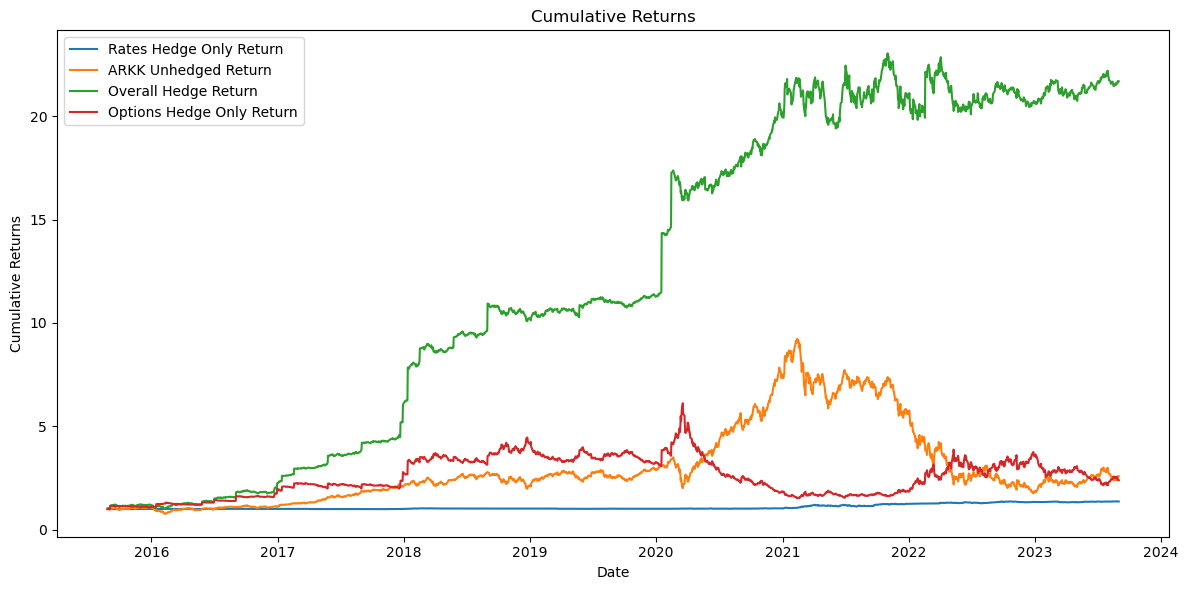

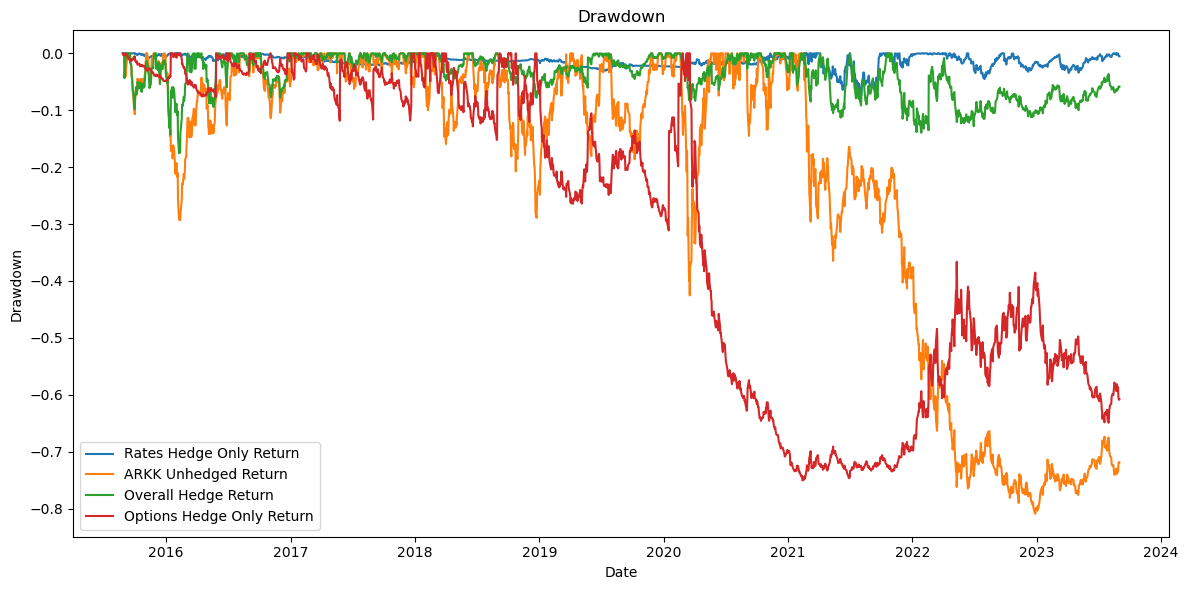

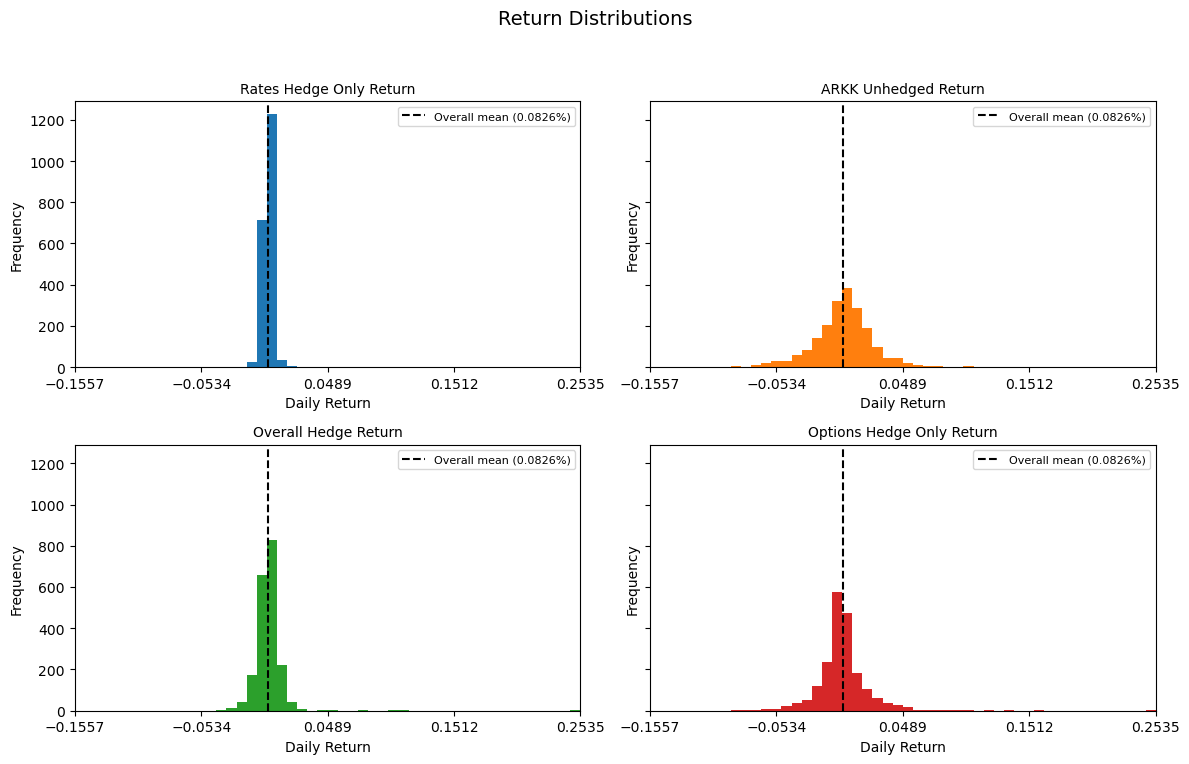

In [6]:
cols = [
    "Rates Hedge Only Return",
    "ARKK Unhedged Return",
    "Overall Hedge Return",
    "Options Hedge Only Return"
]

bt = ComparisonBacktest(combined, cols)
bt.plot_cumulative_returns()
bt.plot_drawdowns()
bt.plot_return_distributions()

In [11]:
ark_unhedged = combined[['date','ARKK Unhedged Return']]
ark_unhedged = ark_unhedged.rename(columns={'ARKK Unhedged Return': 'daily_return'})
ark_unhedged

,date,daily_return
0,2015-08-27,0.030805
1,2015-08-28,0.009778
2,2015-08-31,-0.006917
3,2015-09-01,-0.036318
4,2015-09-02,0.011100
...,...,...
2007,2023-08-28,0.002685
2008,2023-08-29,0.054284
2009,2023-08-30,0.006927
2010,2023-08-31,0.003210


Annualized Sharpe                        : 0.4345622050562352
Annualized Sortino                       : 0.5936346763458317
Information Ratio                        : 0.16015169360988932
Downside Beta                            : 1.459566022705589
Max Drawdown                             : -0.8184665075834737
Calmar Ratio                             : 0.2358343816910598
Treynor Ratio                            : 0.11408736983722229
Standard Beta                            : 1.4977483380280932
Omega Ratio                              : 1.0903796845591465
Value at Risk (VaR)                      : -0.04104662768002759
Conditional Value at Risk (CVaR)         : -0.05852586035837132
Max Drawdown Duration                    : 637
Profit Factor                            : 1.0903796845591465
Annualized Return                        : 0.12110070607559487
Annualized Volatility                    : 0.3931934780841963
Recovery Factor                          : 1.8319684762743103
Fama-French Regr

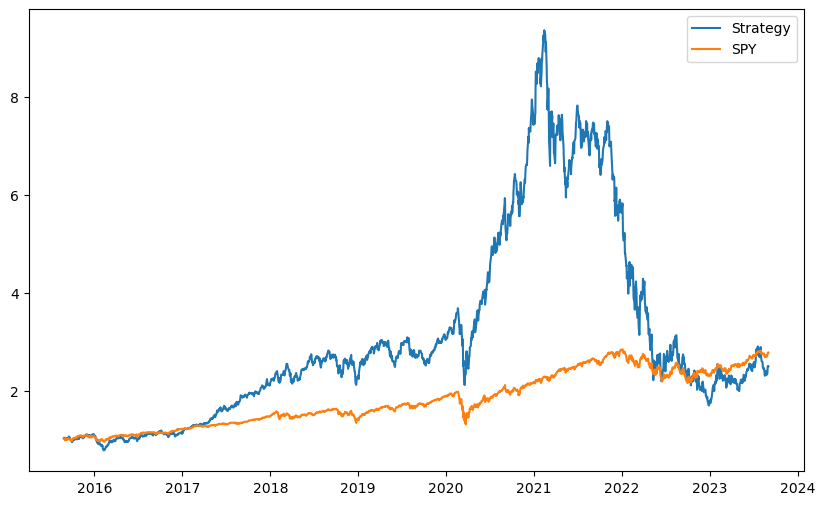

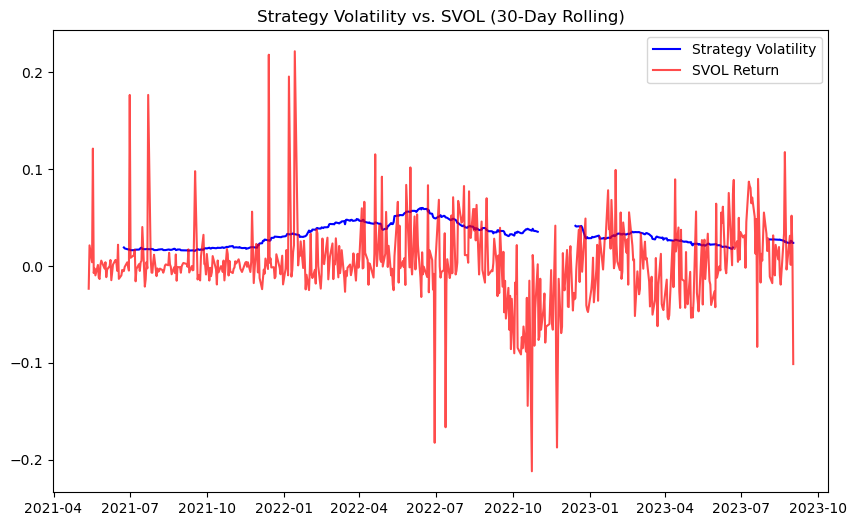

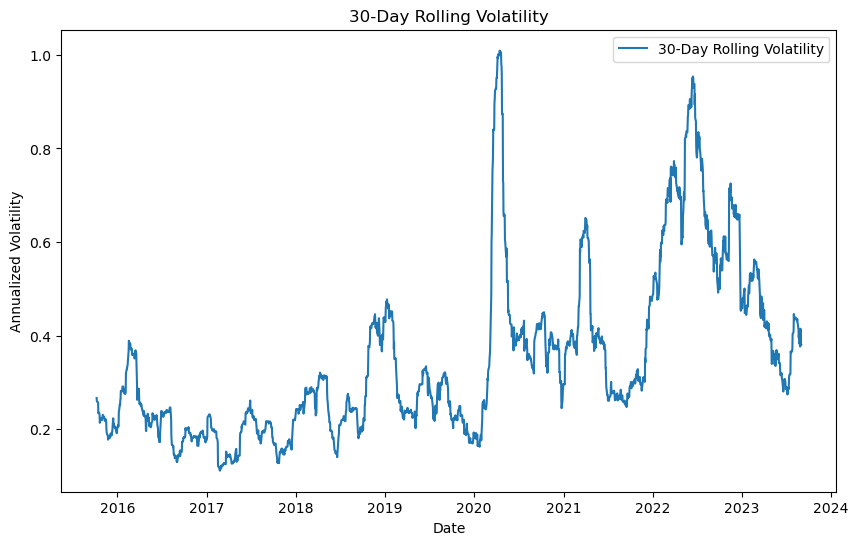

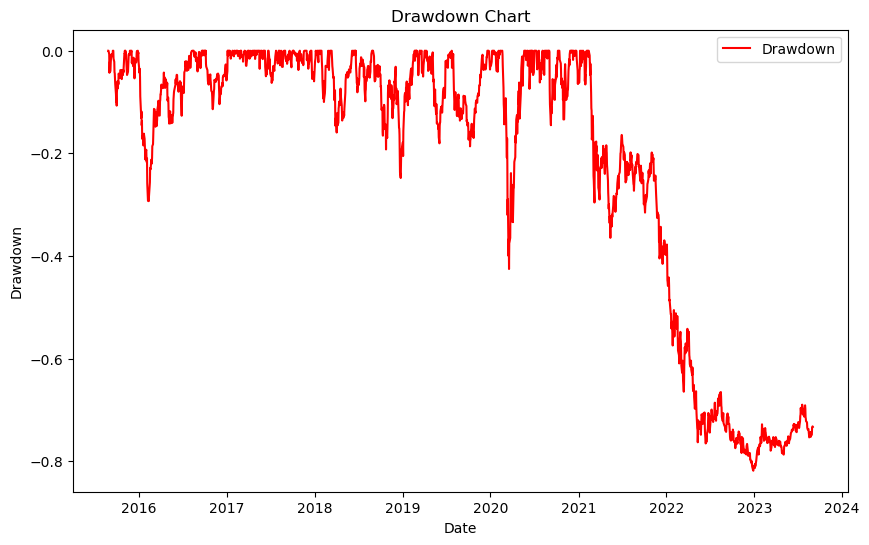

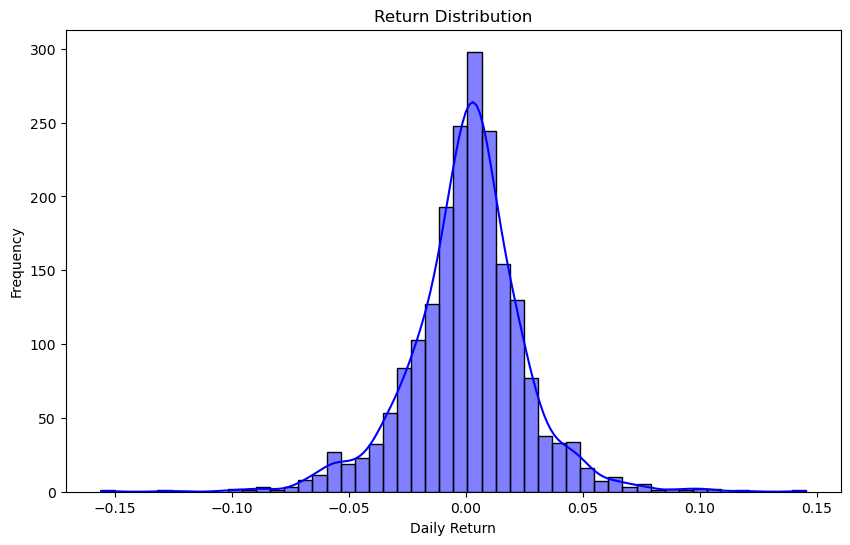

In [12]:
get_backtesting_results(ark_unhedged)

In [9]:
options_hedge = combined[['date',"Options Hedge Only Return",]]
options_hedge = options_hedge.rename(columns={"Options Hedge Only Return": 'daily_return'})
options_hedge

,date,daily_return
0,2015-08-27,0.000240
1,2015-08-28,-0.002575
2,2015-08-31,-0.000071
3,2015-09-01,-0.000372
4,2015-09-02,0.000117
...,...,...
2007,2023-08-28,-0.002204
2008,2023-08-29,-0.045831
2009,2023-08-30,-0.005742
2010,2023-08-31,-0.002622


Annualized Sharpe                        : 0.4304344761010956
Annualized Sortino                       : 0.7418917666296414
Information Ratio                        : 0.07707947043467316
Downside Beta                            : -1.1055579679090846
Max Drawdown                             : -0.7438935902665444
Calmar Ratio                             : 0.24895584570195853
Treynor Ratio                            : -0.1435985263579545
Standard Beta                            : -1.1354453825211441
Omega Ratio                              : 1.1130945389076938
Value at Risk (VaR)                      : -0.030373894956545612
Conditional Value at Risk (CVaR)         : -0.04618106298299665
Max Drawdown Duration                    : 864
Profit Factor                            : 1.1130945389076938
Annualized Return                        : 0.12171915712849479
Annualized Volatility                    : 0.37881284618293515
Recovery Factor                          : 2.030499298838549
Fama-French

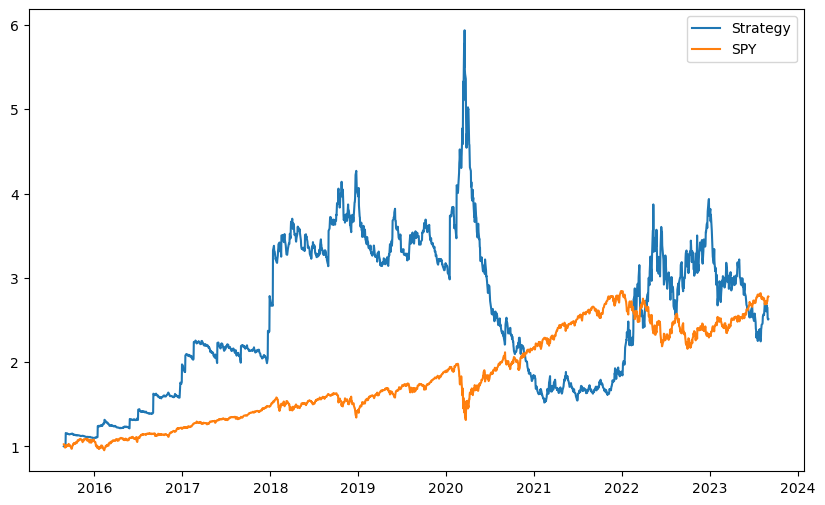

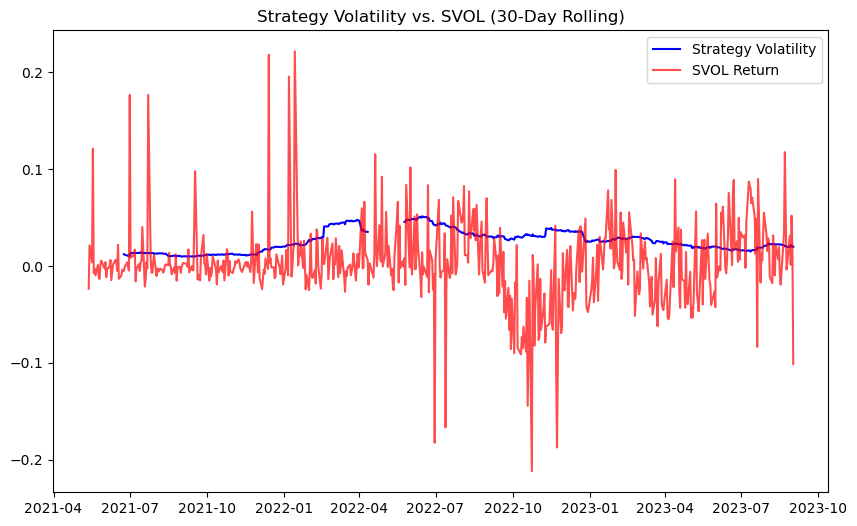

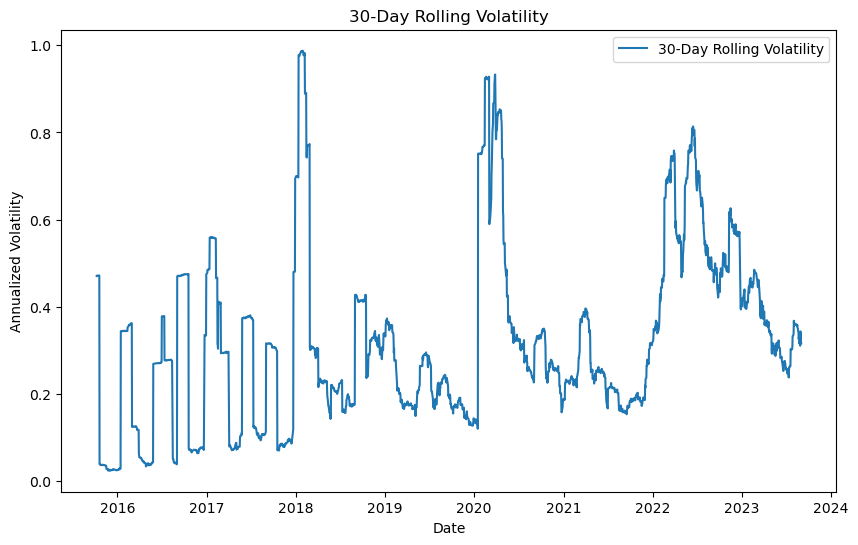

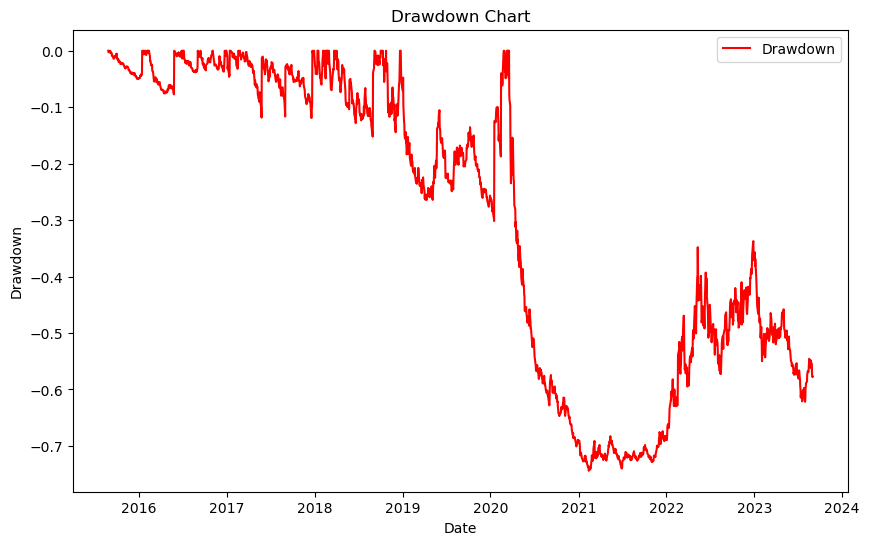

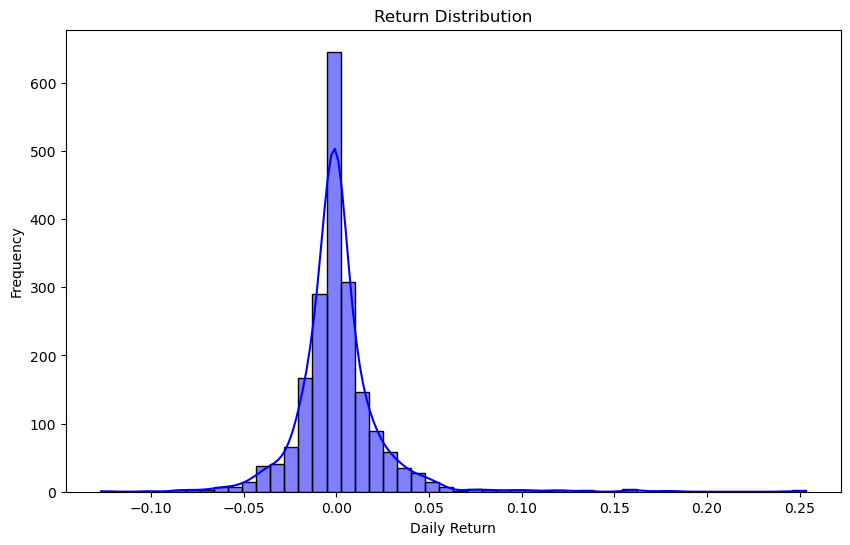

In [10]:
get_backtesting_results(options_hedge)

In [9]:
overall_hedge = combined[['date',"Overall Hedge Return",]]
overall_hedge = overall_hedge.rename(columns={"Overall Hedge Return": 'daily_return'})
overall_hedge

,date,daily_return
0,2015-08-27,0.031045
1,2015-08-28,0.007204
2,2015-08-31,-0.006988
3,2015-09-01,-0.036691
4,2015-09-02,0.011217
...,...,...
2007,2023-08-28,0.000184
2008,2023-08-29,0.004880
2009,2023-08-30,0.000752
2010,2023-08-31,-0.000557


Annualized Sharpe                        : 1.5293028079478863
Annualized Sortino                       : 4.056281384276425
Information Ratio                        : 0.9801432465446924
Downside Beta                            : 0.3514294632690363
Max Drawdown                             : -0.17546371317948384
Calmar Ratio                             : 2.376765393379383
Treynor Ratio                            : 1.097508151720423
Standard Beta                            : 0.3598038943699276
Omega Ratio                              : 1.5924369045989362
Value at Risk (VaR)                      : -0.013064897105217573
Conditional Value at Risk (CVaR)         : -0.019577463692326776
Max Drawdown Duration                    : 457
Profit Factor                            : 1.5924369045989362
Annualized Return                        : 0.4651615214301099
Annualized Volatility                    : 0.25820865025403594
Recovery Factor                          : 115.96635073816215
Fama-French Regre

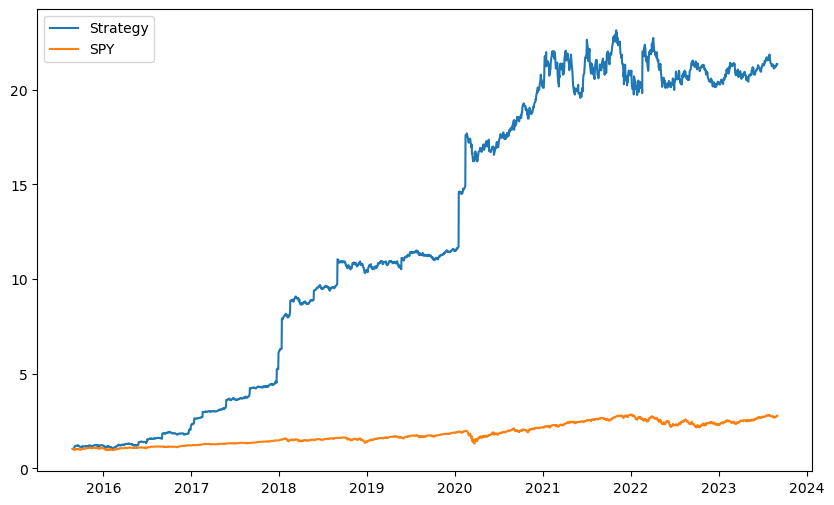

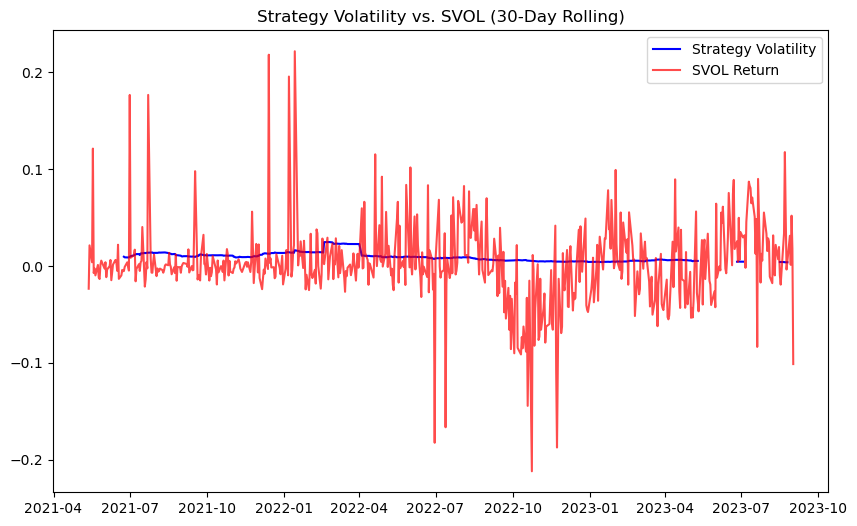

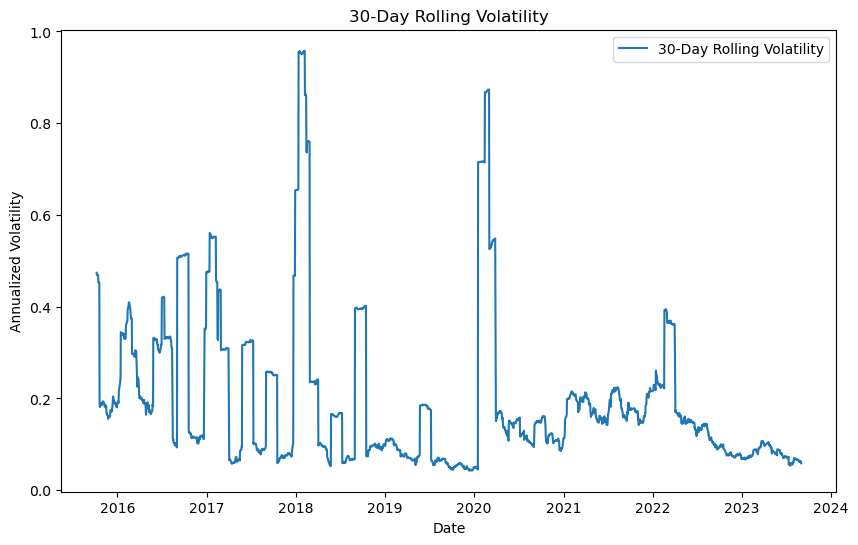

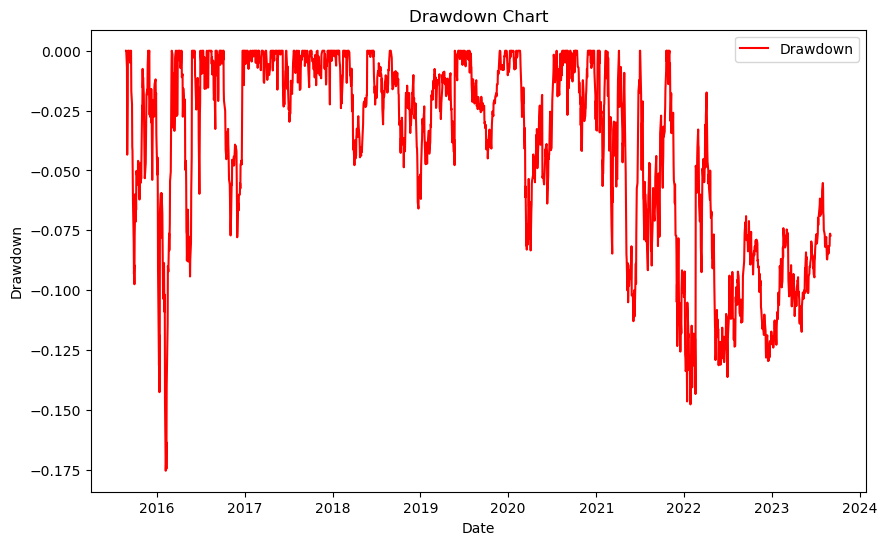

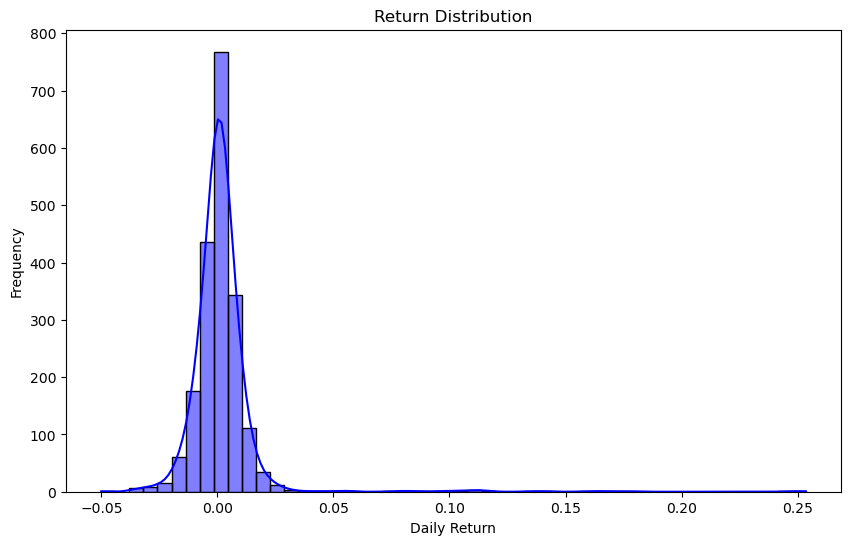

In [11]:
get_backtesting_results(overall_hedge)